# Классификация комментариев (анализ тональности)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек-и-настройка-окружения" data-toc-modified-id="Импорт-библиотек-и-настройка-окружения-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек и настройка окружения</a></span></li><li><span><a href="#Загрузка-и-изучение-данных" data-toc-modified-id="Загрузка-и-изучение-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и изучение данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-DistilBERT" data-toc-modified-id="Модель-DistilBERT-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель DistilBERT</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель**

- Построить модель машинного обучения, которая поможет классифицировать комментарии на позитивные и негативные c качесвтом по метрике F1 не меньше 0.75. Использовать в проекте модель DistillBERT


# Описание данных
**Признак**
- text — текст комментария

**Целевой признак**
- toxic — определяет позитивный или негативный комментарий 

# Инструменты
- Язык - `Python`
- `pandas` `numpy` `matplotlib` `seaborn` `scikit-learn` `re` `nltk` `torch` `transformers` `tqdm` `wordcloud` `catboost` `DistillBERT`

## Подготовка

### Импорт библиотек и настройка окружения

Установим библеотеку `transformers`

In [1]:
# pip install transformers

In [2]:
# pip install scikit-learn --upgrade --user

Установим библиотеку Natural Language Toolkit

In [3]:
# pip install nltk

Установим CatBoost

In [4]:
# !pip install catboost

Установим библиотеку WordCloud

In [5]:
# pip install wordcloud

Импортируем необходимые библиотеки

In [6]:
import numpy as np
import pandas as pd

# Библиотека для очистки данных
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# PyTorch применяется в задачах обработки естественного текста и компьютерного зрения
import torch

# В библиотеке transformers находятся модели типа BERT
import transformers

# Для отслеживания прогресса выполнения кода
from tqdm import notebook

# Визуализация
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# Подготовка данных и обучение моделей
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import catboost
from catboost import Pool
from catboost import CatBoostClassifier

# Перемешивание датасета
from sklearn.utils import shuffle

# Метрики качества
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to C:\Users\Mr.
[nltk_data]     D\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Mr.
[nltk_data]     D\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Настроим использование графического процессора вместо цифрового для процедуры эмбеддинга

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
torch.cuda.is_available()

True

### Загрузка и изучение данных

Загрузим данные

In [9]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')

except:
    data = pd.read_csv('toxic_comments.csv')

Выведем на экран основную информацию по датасету

In [10]:

print(f' Рассмотрим датафрейм')

print('\n Форма:')
print(data.shape)   
print('\n Общая информация:')
print(data.info())
print('\n Первые пять объектов:')
display(data.head())
print('\n Количество признаков:')
display(len(data.columns))
print('\n Описательные характеристики:')
display(data.describe().T)
print('\n Максимальное количество пропусков для одного признака:')
print(data.isna().sum().max())

# Проверим наличие дубликатов
print('\n Проверим наличие явных дубликатов:')
print(data.duplicated().sum())

# Распределение по классам
print(f"Количество строк по классам: {np.bincount(data['toxic'])}")

 Рассмотрим датафрейм

 Форма:
(159571, 2)

 Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None

 Первые пять объектов:


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0



 Количество признаков:


2


 Описательные характеристики:


,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.101679,0.302226,0.0,0.0,0.0,0.0,1.0



 Максимальное количество пропусков для одного признака:
0

 Проверим наличие явных дубликатов:
0
Количество строк по классам: [143346  16225]


**Лемматизация**

Инициализируем инструмент WordNetLemmatizer из библиотеки nltk

In [11]:
wnl = WordNetLemmatizer()

Создадим функцию лемматицазии данных

In [12]:
def lem(text):
    join_text = ' '.join(text + 'bbrrr')
    words_lem = wnl.lemmatize(join_text)
    join_lem_text = ''.join(words_lem).split(sep='bbrrr')

    return join_lem_text[:len(text)]    

Лемматизируем текст, вызвав функцию

In [13]:
%%time
data['text'] = lem(data['text'])
data['text'] = lem(data['text'])

Wall time: 4.21 s


**Добавление признаков**

Напишем функцию очистки текта, которая оставит только латиницу

In [14]:
def clear_text(text):
    split_substitute = re.sub(r'[^a-zA-Z]',' ', text).split()
    return ' '.join(split_substitute)


Применим фунцкцию

In [15]:
data['text'] = data['text'].apply(clear_text)

Добавим параметр - длина текста

In [16]:
data['len_text'] = data['text'].apply(lambda x: len(x))

Удалим строки, длина которых менее одного

In [17]:
data = data[data['len_text'] > 1] 

Добавим параметр - средняя длина предложения

In [18]:
data['avg_len_sentence'] = data.loc[:,'text'].apply(lambda x:
                                            [len(sentence) for sentence in x.split('.')
                                             if len(sentence) != 0])\
                                    .apply(lambda x: sum(x) / len(x))

Отобразим первые пять строк, чтобы проверить преобразования

In [19]:
data.head()

,text,toxic,len_text,avg_len_sentence
0,Explanation Why the edits made under my userna...,0,248,248.0
1,D aww He matches this background colour I m se...,0,88,88.0
2,Hey man I m really not trying to edit war It s...,0,229,229.0
3,More I can t make any real suggestions on impr...,0,601,601.0
4,You sir are my hero Any chance you remember wh...,0,63,63.0


Создадим отдельные датасеты для положительных и токсичных текстов

In [20]:
data_toxic = data[data['toxic']==1]
data_positive = data[data['toxic']==0]

**Построим гистограммы распределения**

Напишем функцию построения распределений

In [21]:
def plot_text(data, col1, col2, group_col, title_1, title_2, subtitle):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15), dpi=300)
    (ax1, ax2), (ax3, ax4) = axes
    sns.histplot(data, x=col1, hue=group_col, ax=ax1, kde=True)
    ax1.set_title(title_1)
    sns.histplot(data, x=col2, hue=group_col, ax=ax2, kde=True)
    ax2.set_title(title_2)
    sns.histplot(data, x=col1, hue=group_col, ax=ax3, kde=True)
    ax3.set_title(f'{title_1} (максимальное значение 1000)')
    ax3.set_xlim(0,1000)
    sns.histplot(data, x=col2, hue=group_col, ax=ax4, kde=True)
    ax4.set_title(f'{title_2} (максимальное значение 1000)')
    ax4.set_xlim(0,1000)
    fig.suptitle(subtitle)

Установим стиль

In [22]:
sns.set(style="darkgrid", palette="pastel")

Построи гистограммы, вызвав функцию

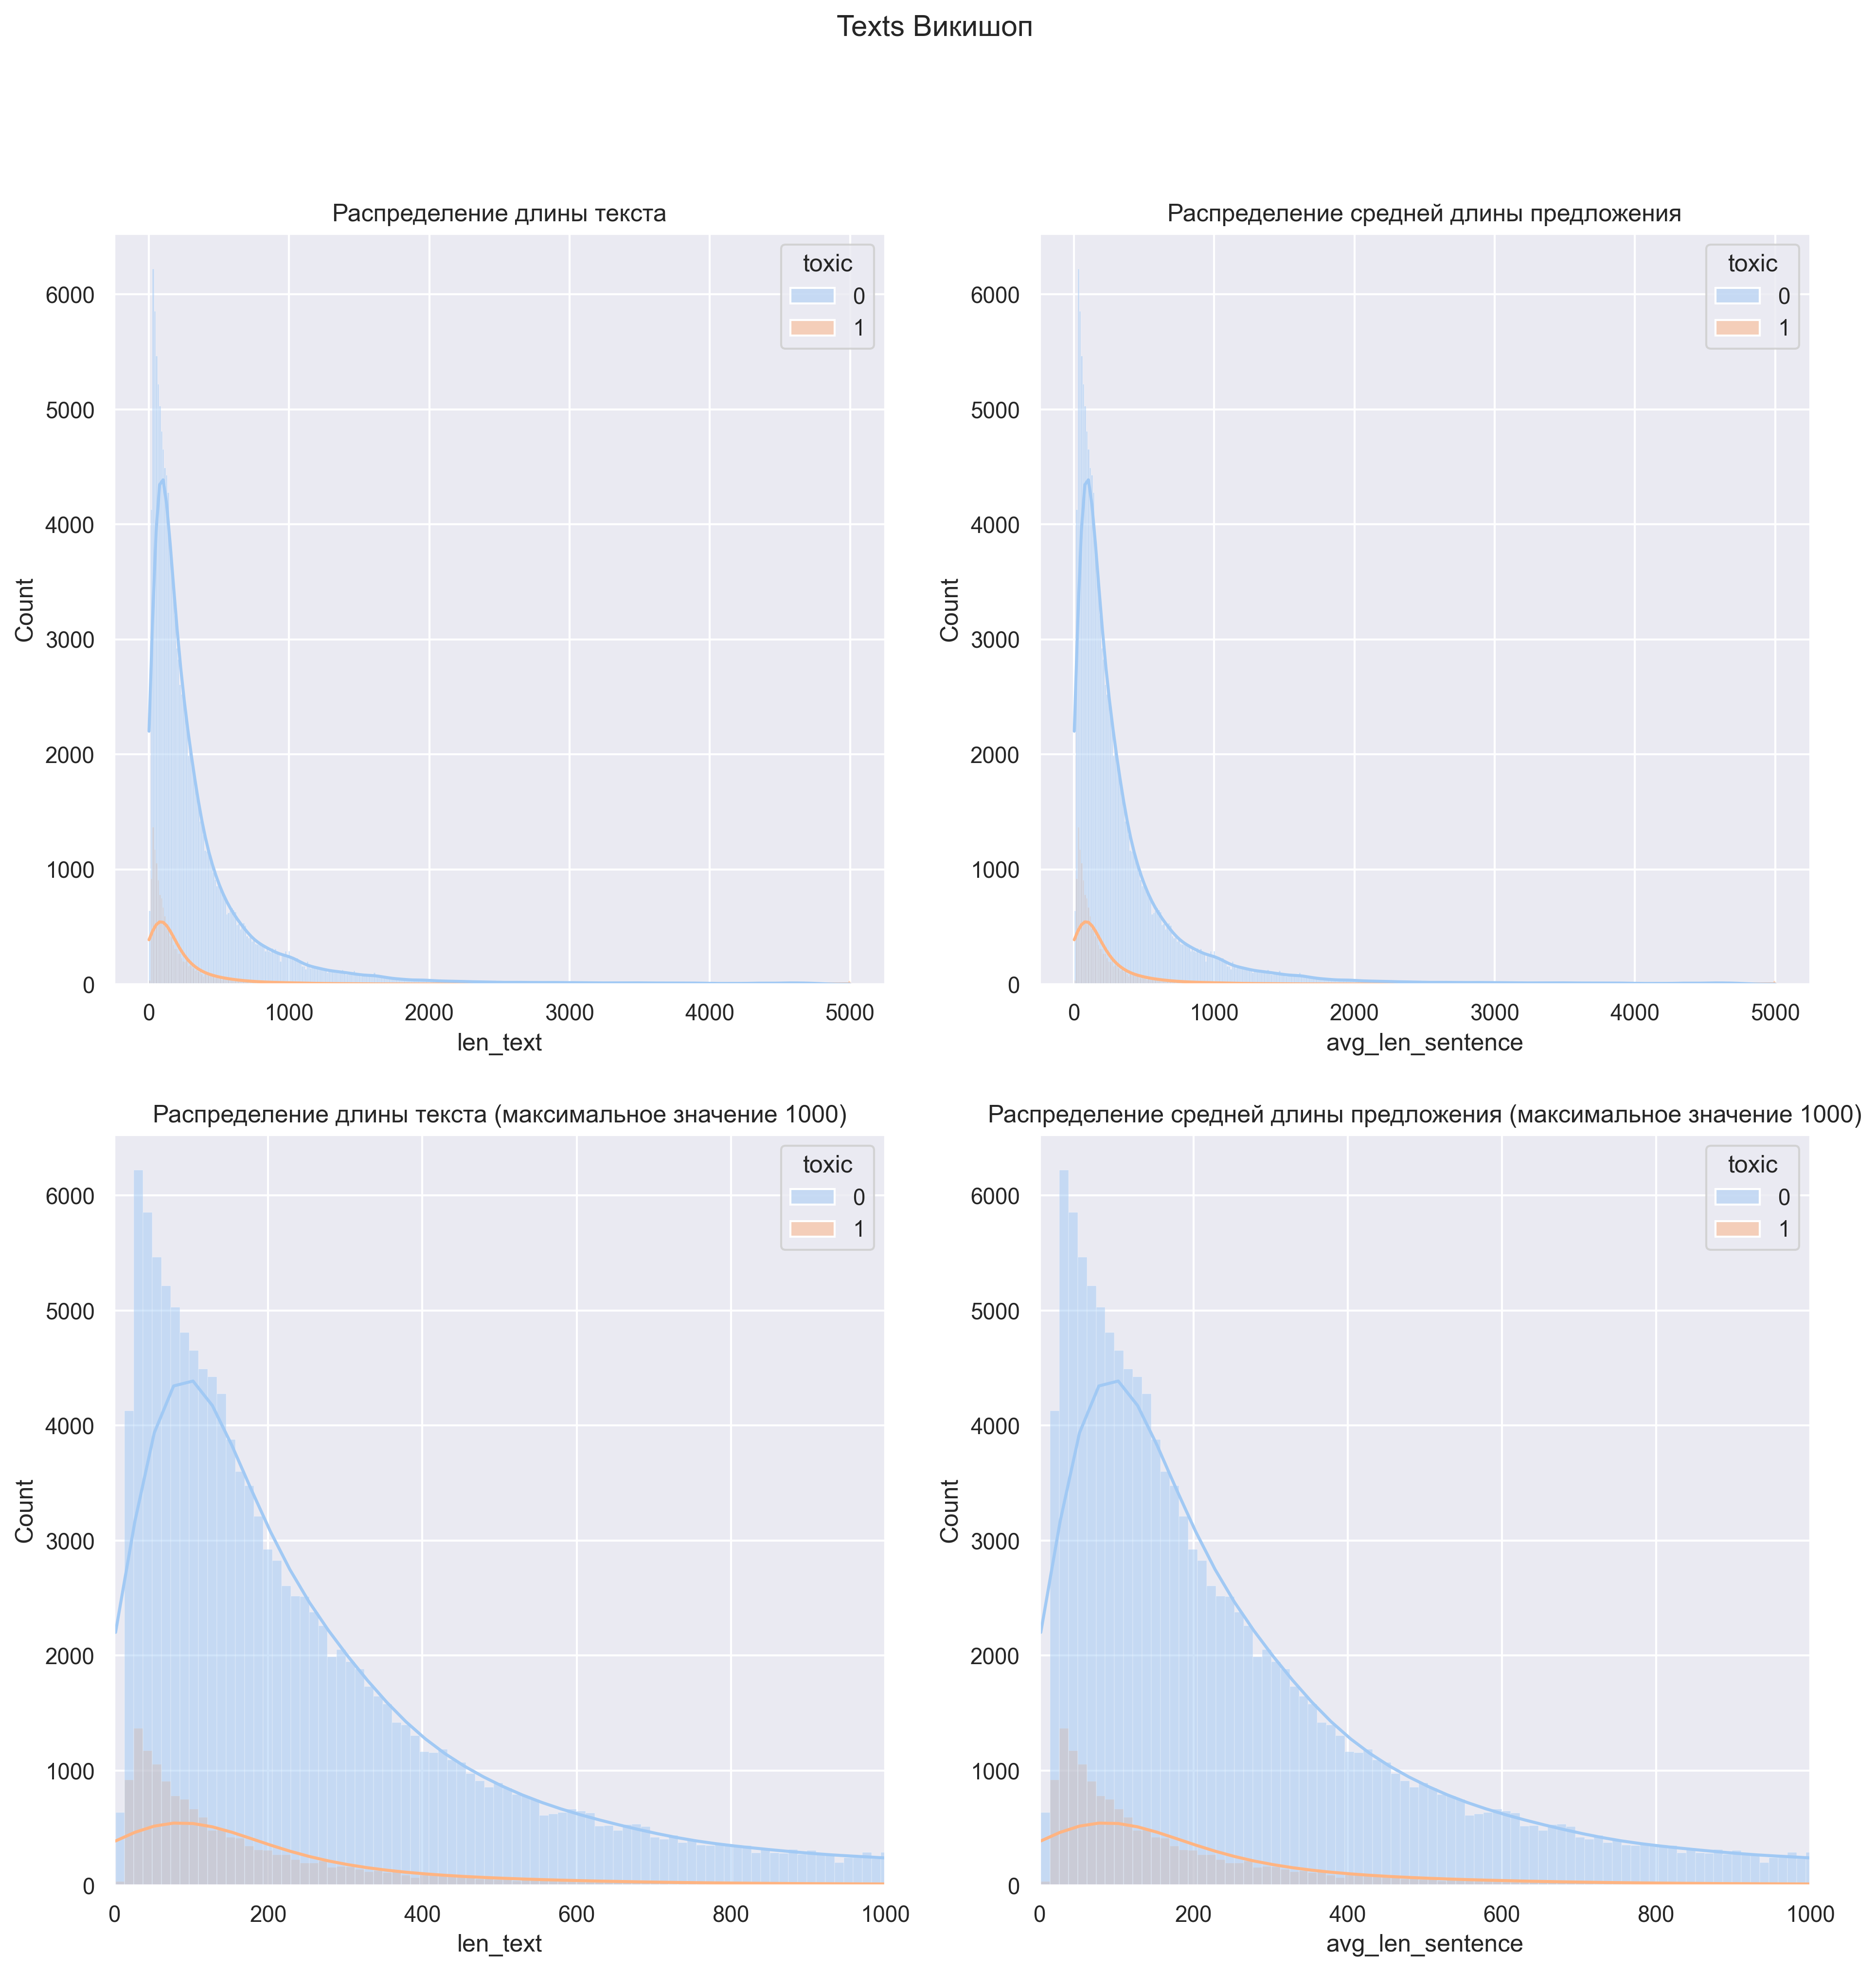

In [23]:
plot_text(data, 'len_text', 'avg_len_sentence', 'toxic',
           "Распределение длины текста","Распределение средней длины предложения","Texts Викишоп")

- Распределие длин текста и средних длин предложения во многом повторяют друг друга. Это связано с тем, что тектсы чаще состоят из одного предложения

**Облако слов для положительных текстов**

Напишем функцию построения облака слов

In [24]:
def words_cloud(text_data):
    plt.figure(figsize=(20,20))
    text = ' '.join(text_data.values)
    WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
    words=WC.generate(text)
    plt.imshow(words, interpolation='bilinear')
    plt.show

Установим стиль

In [25]:
sns.set_style("dark")

Отобразим облако слов, вызвав функцию

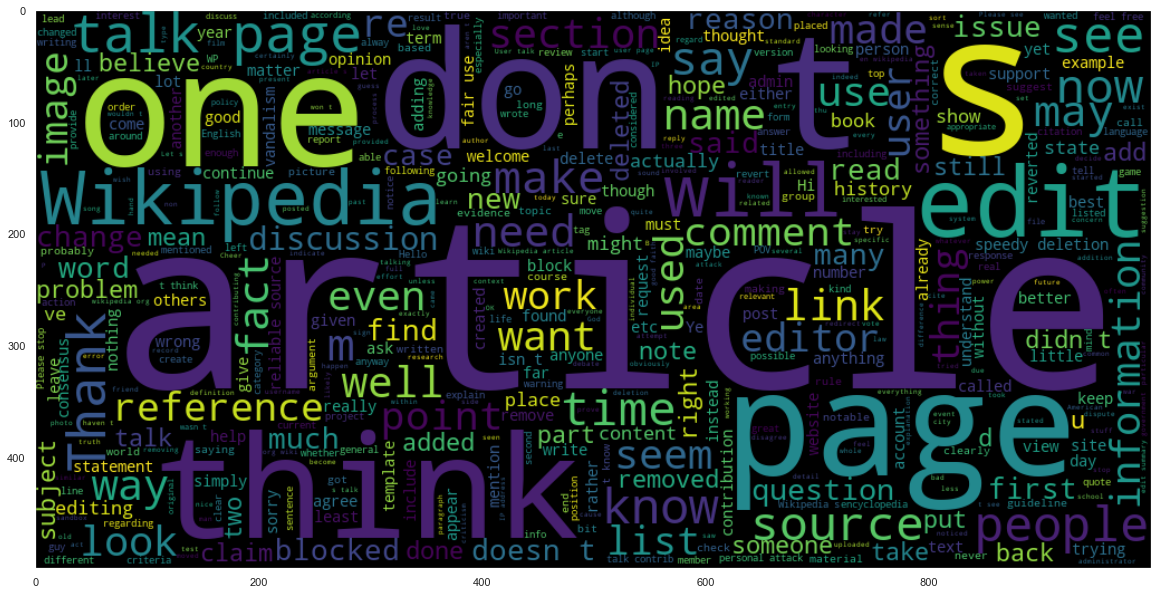

In [26]:
words_cloud(data_positive['text'])

**Облако слов для токсичных текстов**

Отобразим облако слов, вызвав функцию

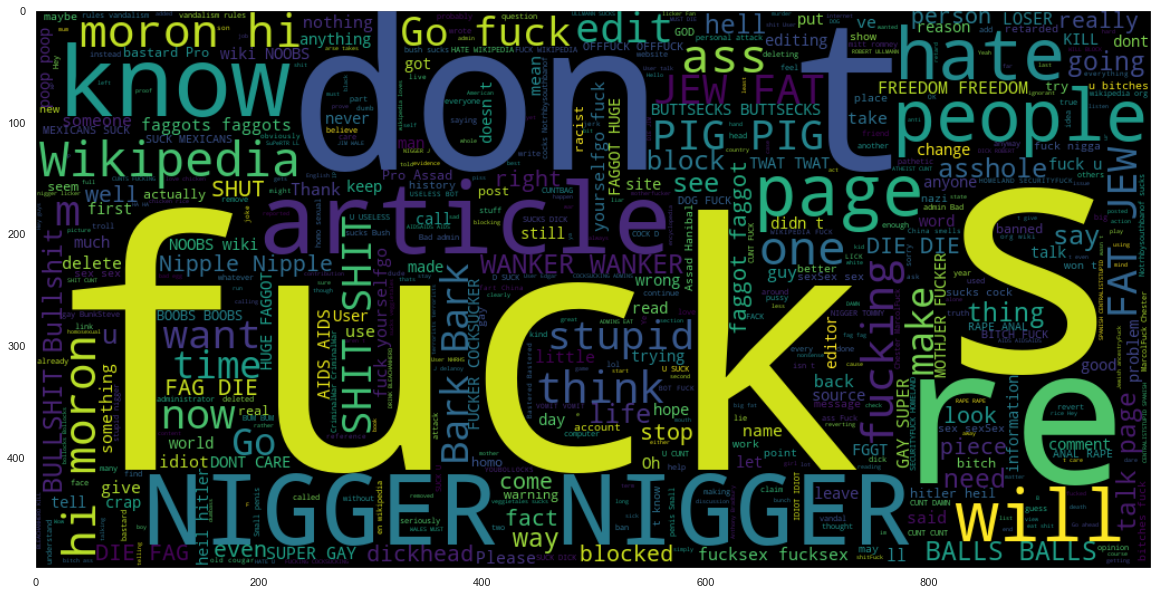

In [27]:
words_cloud(data_toxic['text'])

- В положительных текстах преобладают слова: article, page, wikipedia, thik, edit, one, see, will
- В отрицательных текстах чаще встречается нецензурная лексика

In [28]:
print(f"Количество строк в датасете по классам: \n{data['toxic'].value_counts()}")

Количество строк в датасете по классам: 
0    143339
1     16225
Name: toxic, dtype: int64


**Сформируем датасет**. Ограничим его 4 000 текстов для ускорения работы алгоритма. Для этого выделим по 2000 объектов из выборок: `data_positive и data_toxic`

In [29]:
data_positive = data_positive[['text','toxic']].sample(2000)
data_toxic = data_toxic[['text','toxic']].sample(2000)

Объединим и перемешаем датасеты

In [30]:
data = shuffle(pd.concat([data_positive, data_toxic], ignore_index=True))

Отобразим первые десять строк

In [31]:
data.head(10)

,text,toxic
2467,Stop messing with my userpage I can see from t...,1
481,Kenatipo it is not for you to remove informati...,0
235,One of the most important and strongest source...,0
3980,YOU SAY WHY U DELETE AGAIN U DUN LET ME COMMEN...,1
209,It was actually copied from somewhere else We ...,0
2129,Jimmy Tressel locker room orgy The fact that y...,1
2564,This guy needs to get laid soon The loss of vi...,1
1386,splitting Early Web Browsers and OS This histo...,0
3781,YOU SCUMBAG listen I don t know what makes you...,1
3141,n i g g e r f a g g o t,1


Проверим баланс классов

In [32]:
print(f"Количество строк в датасете по классам: \n{data['toxic'].value_counts()}")

Количество строк в датасете по классам: 
1    2000
0    2000
Name: toxic, dtype: int64


Удалим ненужные переменные

In [33]:
del data_toxic, data_positive

## Обучение

Эмбеддинг выполним моделью DistilBERT. Затем протестируем данные на четырех моделях - логистическая регрессия, XGBoost, LightGBM и CatBoostClassifier.

### Модель DistilBERT

Загрузка предобученной модели DistilBERT и токенизатора

In [34]:
model_class, tokenizer_class, pretrained_weights = (
    transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased'
)

Загрузка предобученной модели/токенизатора 

In [35]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


В модели DistilBERT есть ограничение по количеству токенов, их число не должно превышать допустимое значение в 512 токенов.

Выполним токенизацию с помощью функции

In [36]:
tokenized = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

Рассчитаем максимальную длину текста и сохраним в переменную

In [37]:
max_len = 0
ind = 0
all_len = []
for a, i in enumerate(tokenized.values):
    all_len.append(len(i))
    if len(i) > max_len:
        max_len = len(i)
        ind = a 
print(f'Максимальная длина: {max_len}')
print('Количество текстов длиной более 512: {}'.format((pd.Series(all_len) > 512).sum()))

Максимальная длина: 512
Количество текстов длиной более 512: 0


Применим метод `padding`, чтобы после токенизации длины исходных текстов в корпусе были равными. Только в этом случае модель DistilBERT сможет работать

In [38]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

Укажем, что нулевые значения необходимо игнорировать

In [39]:
attention_mask = np.where(padded != 0, 1, 0)

Модель DistilBERT создает эмбеддинги батчами. Чтобы хватило оперативной памяти сделаем размер батча небольшим

In [40]:
batch_size = 20

Сделаем пустой список для хранения эмбеддингов

In [41]:
embeddings = []

Сделаем цикл по батчам. Отображать прогресс будет функция `notebook()`

In [42]:
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        
        # Преобразуем данные в формат тензоров (англ. tensor) — многомерных 
        # векторов в библиотеке torch. Тип данных LongTensor хранит числа в «длинном 
        # формате», то есть выделяет на каждое число 64 бита.
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        # Функцией no_grad() библиотеки torch укажем, что обучать модель не будем.
        # Это позволит ускорить процесс эмбеддинга
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        # Добавим эмбеддинги в список embeddings
        # Преобразуем эмбеддинги в массив numpy
        batch_emb = batch_embeddings[0][:,0,:].cpu().numpy()
        embeddings.append(batch_emb)

  0%|          | 0/200 [00:00<?, ?it/s]

Разделим датасет на признаки и целевой признак

In [43]:
target = data['toxic']
features = np.concatenate(embeddings)

Разделим датасет на обучающую и тестовую выборки

In [44]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=target)

In [45]:
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [1500 1500]
Количество строк в target_test по классам: [500 500]


### Логистическая регрессия

Создадим пустой список, в который будем записывать результаты оценки качества моделей

In [46]:
f1_test = []

Инициализируем модель

Установим максимальное количество итераций 1000 (по умолчанию - 100). Иначе появляется предупреждение:

>ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT



In [47]:
lr = LogisticRegression(class_weight = 'balanced', max_iter = 500, solver='liblinear', random_state=34)

Обучим модель и сделаем предсказание

In [48]:
lr.fit(features_train, target_train)
lr_pred_test = lr.predict(features_test)

Оценим качество

In [49]:
cvs_test = cross_val_score(lr, features_test, target_test, scoring='f1')
print(cvs_test.mean())

0.8800767759002521


In [50]:
f1_test.append(cvs_test.mean())

### XGBoost

Создадим модель

In [51]:
xgb = XGBClassifier(verbosity = 0, random_state=34)

Подберем оптимальные гиперпараметры модели случайного леса. Воспользуемся инструментом `RandomizedSearchCV` модуля `selection` из библиотеки `sklearn`

In [52]:
%%time

# Зададим параметры, среди которых необходимо найти лучшую комбинацию
# метод np.linspace позволяет установить интервал и количество точек в нем,
# которые нужно перебрать
learning_rate = [0.1, 0.5]
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 15)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]

# Создадим словарь гиперпараметров
param_dist = { 'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth}


# Зададим RandomizedSearchCV
xgb_rs = RandomizedSearchCV(xgb, 
                        param_dist, 
                        n_iter = 10, 
                        cv = 5,
                        n_jobs=9)


# Обучим RandomizedSearchCV
xgb_rs.fit(features_train, target_train)

Wall time: 2min 25s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None

In [53]:
print('Лучшие параметры: {}'.format(xgb_rs.best_params_)) 
print('Лучшая оценка: {0:.3f}'.format(np.abs(xgb_rs.best_score_)))

Лучшие параметры: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.5}
Лучшая оценка: 0.871


Сохраним модель с лучшими параметрами в перенную

In [54]:
xgb_best = xgb_rs.best_estimator_

Обучим модель и сделаем предсказание

In [55]:
xgb_best.fit(features_train, target_train)
xgb_pred_test = xgb_best.predict(features_test)

Оценим качество

In [56]:
cvs_test = cross_val_score(xgb_best, features_test, target_test, scoring='f1')
print(cvs_test.mean())

0.8652995239538349


In [57]:
f1_test.append(cvs_test.mean())

### LightGBM

Создадим модель

In [58]:
lgbm = LGBMClassifier(verbose = -1, force_col_wise=True, random_state=34)

Подберем оптимальные гиперпараметры модели случайного леса. Воспользуемся инструментом `RandomizedSearchCV` модуля `selection` из библиотеки `sklearn`

In [59]:
%%time

# Зададим параметры, среди которых необходимо найти лучшую комбинацию
# метод np.linspace позволяет установить интервал и количество точек в нем,
# которые нужно перебрать
learning_rate = [0.1, 0.3]
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 30, num = 5)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]


# Создадим словарь гиперпараметров
param_dist = { 'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth}

# Зададим RandomizedSearchCV
lgbm_rs = RandomizedSearchCV(lgbm,
                            param_dist,
                            n_iter = 10,
                            cv = 5,
                            verbose=0,
                            n_jobs=9)


# Обучим RandomizedSearchCV
lgbm_rs.fit(features_train, target_train)

Wall time: 5.55 s


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_col_wise=True,
                                            random_state=34, verbose=-1),
                   n_jobs=9,
                   param_distributions={'learning_rate': [0.1, 0.3],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [1, 8, 15, 22, 30]})

In [60]:
print('Лучшие параметры: {}'.format(lgbm_rs.best_params_)) 
print('Лучшая оценка: {0:.3f}'.format(np.abs(lgbm_rs.best_score_)))

Лучшие параметры: {'n_estimators': 15, 'max_depth': 4, 'learning_rate': 0.1}
Лучшая оценка: 0.848


Сохраним модель с лучшими параметрами в перенную

In [61]:
lgbm_best = lgbm_rs.best_estimator_

Обучим модель и сделаем предсказание

In [62]:
lgbm_best.fit(features_train, target_train)
lgbm_pred_test = xgb_best.predict(features_test)

Оценим качество

In [63]:
cvs_test = cross_val_score(lgbm_best, features_test, target_test, scoring='f1')
print(cvs_test.mean())

0.8306517662391453


In [64]:
f1_test.append(cvs_test.mean())

### CatBoost

Создадим обучающий и тестовый пулы данных

In [65]:
train_pool = catboost.Pool(features_train, target_train)
test_pool = catboost.Pool(features_test, target_test)

Создадим модель

In [66]:
cbc = CatBoostClassifier(eval_metric='F1', verbose = False, random_state=34)

Найдем гиперпараметры модели с помощью встроенного в CatBoost `randomized_search` 

In [67]:
%%time

# Зададим параметры, среди которых необходимо найти лучшую комбинацию
# метод np.linspace позволяет установить интервал и количество точек в нем,
# которые нужно перебрать
learning_rate = [0.1, 0.5]
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 15)]
depth = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]


# Создадим словарь гиперпараметров
param_dist = { 'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'depth': depth}

# Зададим RandomizedSearch
cbc_rs = cbc.randomized_search(
                            param_dist,
                            train_pool,
                            n_iter = 5,
                            cv = 5,
                            verbose = False,
                            shuffle=False,
                            plot=True
                           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8507718696
bestIteration = 89


bestTest = 0.8432055749
bestIteration = 23


bestTest = 0.8432055749
bestIteration = 23


bestTest = 0.8665511265
bestIteration = 75


bestTest = 0.8571428571
bestIteration = 46

Training on fold [0/5]

bestTest = 0.8647746244
bestIteration = 121

Training on fold [1/5]

bestTest = 0.8785357737
bestIteration = 112

Training on fold [2/5]

bestTest = 0.8704318937
bestIteration = 125

Training on fold [3/5]

bestTest = 0.8836424958
bestIteration = 72

Training on fold [4/5]

bestTest = 0.852233677
bestIteration = 65

Wall time: 15.3 s


Отобразим наиболее оптимальные параметры

In [68]:
print(cbc_rs['params'])

{'depth': 3, 'iterations': 128, 'learning_rate': 0.1}


Оценим качество предсказания на обучающих данных

In [69]:
cbc_pred = cbc.predict(features_test)
f1_score(target_test, cbc_pred)

0.8785425101214576

In [70]:
cvs_test = cross_val_score(cbc, features_test, target_test, scoring='f1', verbose=False)
print(cvs_test.mean())

0.867669348120379


In [71]:
f1_test.append(cvs_test.mean())

## Выводы

Отобразим качество классификации текстов двух наборов моделей:  
- DestillBERT + LogisticRegression
- DestillBERT + XGBoost
- DestillBERT + LightGBM
- DestillBERT + CatBoostClassifier

In [72]:
pd.DataFrame(data={'F1_score':f1_test}, index=['LogisticRegression','XGBoost', 'LightGBM', 'CatBoostClassifier'])

,F1_score
LogisticRegression,0.880077
XGBoost,0.865300
LightGBM,0.830652
CatBoostClassifier,0.867669


Построим графики ROC curve для каждой модели

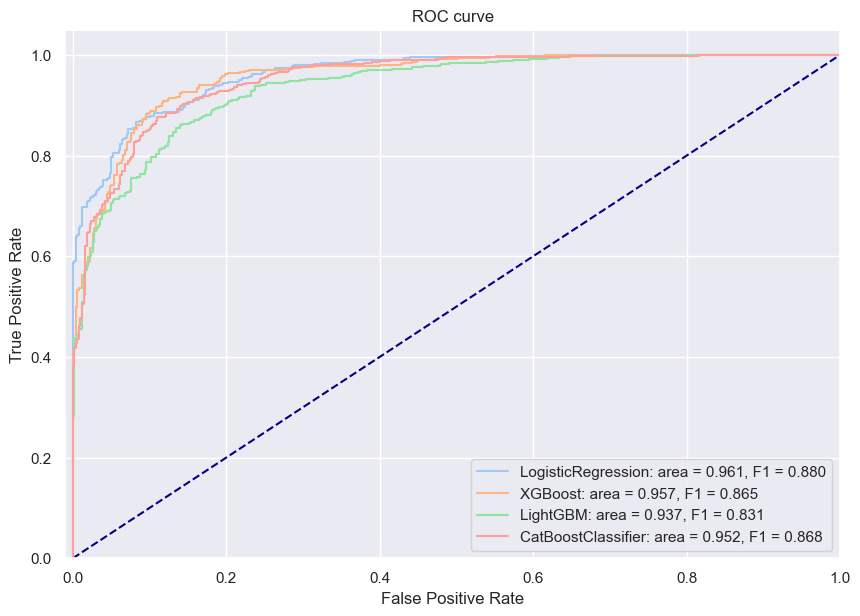

In [73]:
# Создадим списки с моделями и их названиями
models = [lr, xgb_best, lgbm_best, cbc]
names = ['LogisticRegression', 'XGBoost', 'LightGBM', 'CatBoostClassifier']

# Установим стиль
sns.set(style="darkgrid", palette="pastel")

# Создадим основу для графика
plt.figure(figsize=(10,7), dpi=100)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')


# Запишем цикл, в теле которого будут выполняться расчеты для построения графиков ROC и метрики F1
for i, model in enumerate(models):
    
    # Оценим вероятности классов на тестовой выборке
    model_prob_test = model.predict_proba(features_test)
    
    # Рассчитаем roc-кривую
    fpr, tpr, treshold = roc_curve(target_test, model_prob_test[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Построим график
    
    plt.plot(fpr, tpr,label='{0}: area = {1:.3f}, F1 = {2:.3f}'
             .format(names[i], roc_auc, f1_test[i]))
plt.legend(loc="lower right")    
plt.show()

- Как видно из таблицы, наиболее качественной оказалась связка моделей DestillBERT + LogisticRegression
- Выборки из 4000 текстов оказалось достаточно, чтобы достичь необходимого уровня метрики F1